In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

rng  = np.random.default_rng(1234)

In [2]:

def u(t):
    return 1
    return np.sin(0.1*t)+1

delta = 0.5
x0 = 20.
c = 5.

def temperature_mass_system(t,x):
    # delta, x0, c = args
    return -delta*(x-x0) + c*u(t)
    

In [3]:
t = np.arange(0,50.1,0.1)
sol = solve_ivp(
    temperature_mass_system,
    t_span=[t[0],t[-1]],
    t_eval=t,
    y0=[15.],
    method='LSODA'
)

In [4]:
t_true = sol.t
u_true = np.array([u(ti) for ti in t_true])
x_true = sol.y[0]
xdot_true = temperature_mass_system(t_true, x_true)

In [5]:
var = 0.
t_train = t_true[::10]
u_train = np.array([u(ti) for ti in t_train])
x_train = x_true[::10] + var*rng.normal(0,1,x_true[:
                                                   :10].shape)

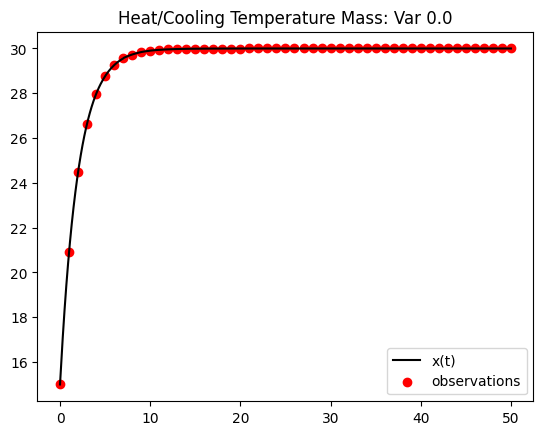

In [6]:
plt.plot(sol.t,sol.y[0], label='x(t)',c='black')
plt.scatter(t_train, x_train, label='observations',c='red')
plt.title(f"Heat/Cooling Temperature Mass: Var {var}")
plt.legend()
plt.show()


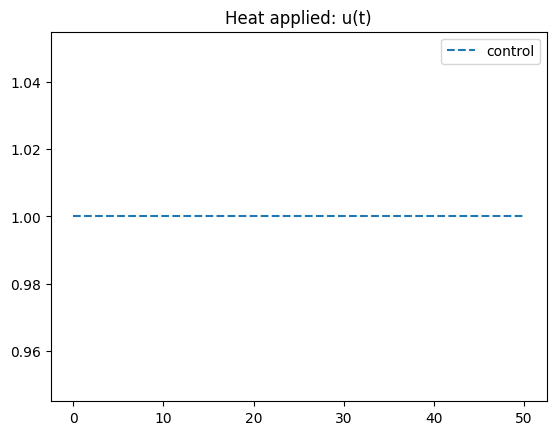

In [7]:
plt.plot(t,[u(ti) for ti in t], linestyle='--',label='control')
plt.title("Heat applied: u(t)")
plt.legend()
plt.show()

# Kernel Method

In [8]:
# just try out of the box opt first
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.gaussian_process.kernels import RationalQuadratic, DotProduct
from scipy.signal import savgol_filter
from scipy.optimize import minimize
from kernels import affine_kernel

In [9]:
x_u_train = np.vstack([x_train,u_train]).T
# K_g = rbf_kernel(x_u_train,x_u_train,gamma=0.1)

In [75]:
# rq_kernel = RationalQuadratic(length_scale=1.0,alpha=1) + DotProduct()
# rq_kernel = DotProduct()
# Kf = rq_kernel(x_train.reshape(-1,1))
# Kf = rbf_kernel(x_train.reshape(-1,1),x_train.reshape(-1,1),gamma=0.01)
# x_u_train = np.vstack([x_train,u_train]).T
# Kg = rbf_kernel(x_u_train,x_u_train,gamma=1)

Kf = affine_kernel(x_train.reshape(-1,1),gamma1=1e-4,gamma2=1)
Kg = affine_kernel(x_u_train,gamma1=1e-4, gamma2=1)




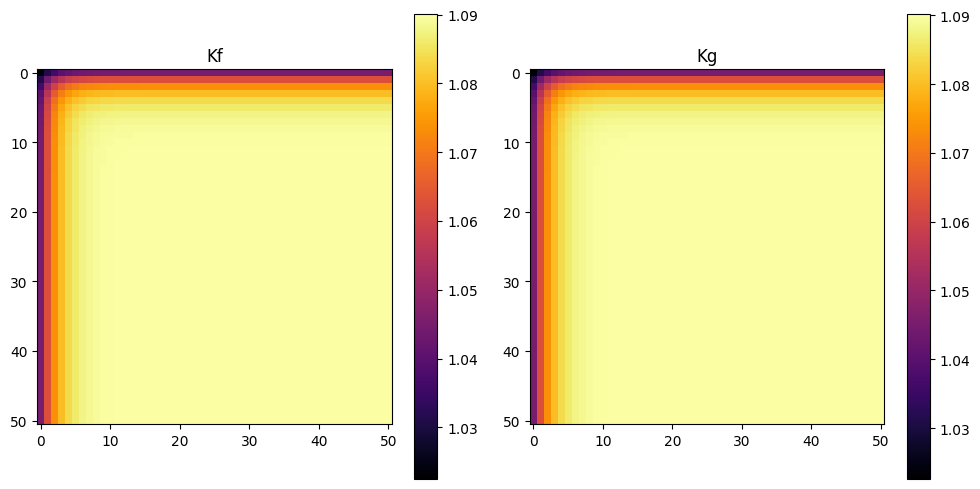

In [76]:
# import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im0 = axs[0].imshow(Kf, cmap='inferno')
axs[0].set_title("Kf")
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(Kg, cmap='inferno')
axs[1].set_title("Kg")
fig.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()


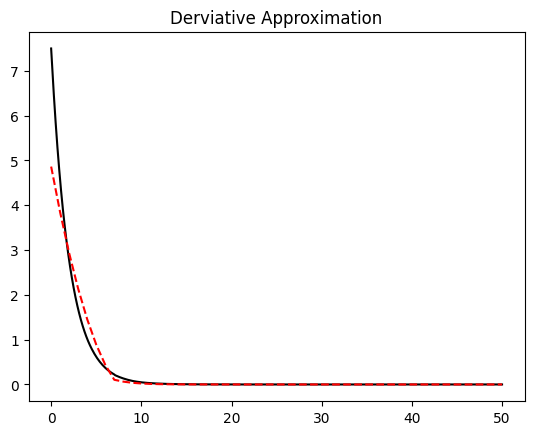

In [77]:
xdot_approx = savgol_filter(x_train, window_length=15,polyorder=3,deriv=1,delta=t_train[1]-t_train[0])

plt.plot(t_true,xdot_true, label="True derviative",c='black')
plt.plot(t_train,xdot_approx,linestyle='--',label='approx',c='red')
plt.title("Derviative Approximation")
plt.show()

In [78]:
N = len(x_train)
a=-1
b=1

eps = 1e-3

def sigmoid(z):
    return 1 / (1+np.exp(-z))

lam_f = 0.01
lam_g = 0.01
def loss_k(params):
    alpha = params[:N]
    beta = params[N:]

    fk = Kf@alpha
    gk = Kg@beta

    # fk = -(fk)**2
    # gk = a + (b-a)*sigmoid(gk)

    resid = xdot_approx - fk*(x_train.flatten() - gk)
    reg = lam_f/2*alpha.T@Kf@alpha + lam_g/2*beta.T@Kg@beta -eps*np.mean((Kf@alpha)**2)
    loss = np.mean(resid**2) + reg
    return loss


In [ ]:
x0_opt = np.zeros(2*N)
sol_opt = minimize(loss_k,x0_opt,method='L-BFGS-B')

In [80]:
alpha_star = sol_opt.x[:N]
beta_star = sol_opt.x[N:]
alpha_star, beta_star

(array([ 9.80038857,  5.74743814,  3.29534118,  1.80123562,  0.8959162 ,
         0.34768779,  0.01005645, -0.19491495, -0.31670279, -0.39147644,
        -0.4350537 , -0.46007596, -0.47534891, -0.48504689, -0.491176  ,
        -0.49496559, -0.49727151, -0.49868636, -0.4995597 , -0.50009955,
        -0.50051977, -0.5009764 , -0.50131362, -0.50153558, -0.50164146,
        -0.50163092, -0.50150179, -0.50146682, -0.50150012, -0.50150387,
        -0.50148091, -0.50142795, -0.50134673, -0.50123571, -0.50120221,
        -0.50117216, -0.50114039, -0.50111748, -0.50108387, -0.50105745,
        -0.50103431, -0.50103103, -0.50102585, -0.5010203 , -0.50101875,
        -0.5010098 , -0.50100652, -0.50100273, -0.5009976 , -0.50099223,
        -0.5009887 ]),
 array([-0.00854199, -0.00678963, -0.00572661, -0.00508171, -0.00468814,
        -0.00444911, -0.00430474, -0.00421603, -0.00416331, -0.00413271,
        -0.00411209, -0.00409775, -0.00409466, -0.00408871, -0.00408605,
        -0.00408616, -0.0040

In [81]:
alpha_star.shape, beta_star.shape, Kg[:5,:5]

((51,),
 (51,),
 array([[1.0226    , 1.03145236, 1.03680817, 1.04007156, 1.04204893],
        [1.03145236, 1.04378757, 1.05125056, 1.05579789, 1.05855324],
        [1.03680817, 1.05125056, 1.05998843, 1.06531257, 1.0685386 ],
        [1.04007156, 1.05579789, 1.06531257, 1.07111002, 1.07462285],
        [1.04204893, 1.05855324, 1.0685386 , 1.07462285, 1.07830947]]))

In [82]:
def f_star(x):
    Kf = rbf_kernel(x,x_train.reshape(-1,1),gamma=1)
    return Kf@alpha_star
    return -(Kf@alpha_star)**2  
    return -np.exp(Kf@alpha_star)

def g_star(x,u):
    input = np.vstack([x,u]).T
    Kg = rbf_kernel(input, x_u_train)
    return Kg@beta_star
    return a + (b-a)*sigmoid(Kg@beta_star)

In [83]:
f_out = f_star(x_train.reshape(-1,1))
g_out = g_star(x_train,u_train)

# xdot_k_approx = f_out*(x_train - g_out)

In [84]:
f_true = np.array([-delta]*len(x_true))
g_true = -delta*(x_true - x0) + c*np.array([u(ti) for ti in t])
g_true = np.array([u(ti) for ti in t]) *c/delta + x0

In [85]:
f_true.shape

(501,)

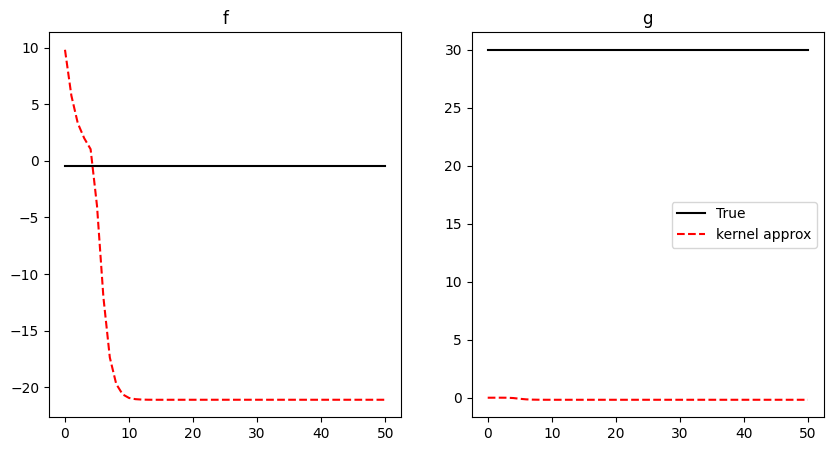

In [86]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

axs[0].plot(t,f_true,c='black')
axs[0].plot(t_train, f_out,linestyle='--',c='red')
axs[0].set_title("f")


axs[1].plot(t,g_true,c='black', label='True')
axs[1].plot(t_train, g_out,linestyle='--',c='red', label='kernel approx')
axs[1].set_title("g")

plt.legend()
plt.show()

In [46]:
c/delta+x0

30.0